<a href="https://colab.research.google.com/github/heitorabqg/datascientist/blob/master/PSI5892_pca1208A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# Análise de componentes principais (PCA) e análise de discriminantes lineares (LDA)

Neste exercício, você vai trabalhar com uma aplicação de redes neurais para  para a área de saúde. O objetivo é obter um modelo de predição de uma doença cardíaca baseado em dados com características extraídas de exames clínicos laboratoriais.

## Dados disponibilizados

Os dados para treinamento e teste do modelo estão disponíveis no formato CSV, em um arquivo zip disponível [neste link](./data.zip).

Após extrair os arquivos, utiliza a biblioteca Pandas para carregar os `DataFrames` `data_train` e `data_test`, como mostrado a seguir:

``` python
import pandas as pd

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])

data_test = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])
```

Os dados consistem de 800 exemplos de treinamento e 225 para teste, cada um contendo 13 características de entrada, representadas pelas colunas de 0 a 12 e a saída desejada binária, indicando se o paciente é portador ou não da doença, representada pela coluna 13.

O objetivo é treinar uma rede neural com estes dados, avaliar o desempenho e depois comparar com o desempenho obtido usando o PCA para realizar redução de dimensionalidade. Use como referência o exemplo mostrado [neste Jupyter Notebook](./PCA_IRIS.ipynb)

# Exercício 1

Implemente uma rede neural para classificar se o indivíduo é portador ou não da doença cardíaca (coluna 13) usando como entrada os dados dos exames laboratoriais (colunas 1 a 12). Calcule a acurácia obtida nos dados de teste.

## Resolução

Época 0 - Loss 0.7146
Época 40 - Loss 0.0607
Época 80 - Loss 0.0141
Época 120 - Loss 0.0016
Época 160 - Loss 0.0003
Época 200 - Loss 0.0002
Época 240 - Loss 0.0002
Época 280 - Loss 0.0001
Época 320 - Loss 0.0000
Época 360 - Loss 0.0001
Época 400 - Loss 0.0000
Época 440 - Loss 0.0000


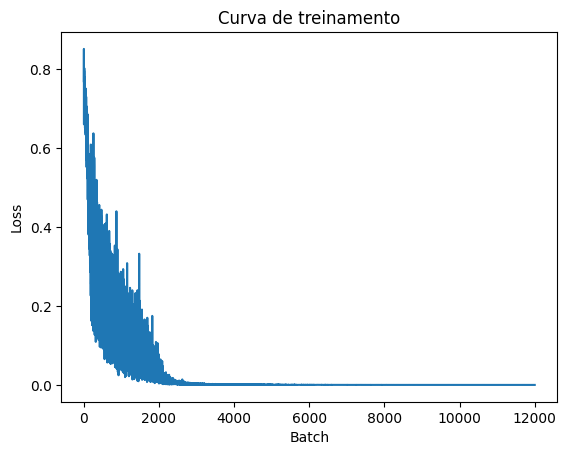

Acurácia no teste = 100.00%


1.0

In [11]:
import torch
import torch.nn as nn
import torch.utils.data as data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar dados
data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test  = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

dados_treino_np = data_train.values
dados_teste_np  = data_test.values


# Normalização dos dados de treino
X_train = dados_treino_np[:, 1:13]
X_test  = dados_teste_np[:, 1:13]

# Média e desvio do treino
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)

# Evita divisão por zero
std[std == 0] = 1.0

# Normaliza
X_train_norm = (X_train - mean) / std
X_test_norm  = (X_test  - mean) / std

# Recria os arrays completos normalizados (saída permanece a mesma)
dados_treino_norm = dados_treino_np.copy()
dados_treino_norm[:, 1:13] = X_train_norm

dados_teste_norm = dados_teste_np.copy()
dados_teste_norm[:, 1:13] = X_test_norm


# Modelo com ReLU
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(12, 16),
            nn.ReLU(),

            nn.Linear(16, 12),
            nn.ReLU(),

            nn.Linear(12, 8),
            nn.ReLU(),

            nn.Linear(8, 2)  # saída binária
        )

    def forward(self, x):
        return self.model(x)


# Dataloader
def criar_dataloader(dados_np, Nb):
    dados = torch.tensor(dados_np, dtype=torch.float32)

    dataset = [
        (dados[i, 1:13], dados[i, 13].long())
        for i in range(dados.shape[0])
    ]

    loader = data.DataLoader(dataset, batch_size=Nb, shuffle=True)
    return loader


# Treinamento
def treino(model, train_loader, Ne, device):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()

    losses = []
    model.to(device)

    for epoch in range(Ne):
        for n, (X, d) in enumerate(train_loader):

            X, d = X.to(device), d.to(device)

            model.train()
            model.zero_grad()

            y = model(X)
            loss = loss_function(y, d)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        if epoch % 40 == 0:
            print(f"Época {epoch} - Loss {loss.item():.4f}")

    plt.figure()
    plt.plot(losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Curva de treinamento")
    plt.show()

    return losses


# Teste
def testar(model, dados_np, device):
    dados = torch.tensor(dados_np, dtype=torch.float32)

    X = dados[:, 1:13].to(device)
    y_true = dados[:, 13].long().to(device)

    model.eval()
    with torch.no_grad():
        logits = model(X)
        pred = torch.argmax(logits, dim=1)

    acc = (pred == y_true).float().mean().item()
    print(f"Acurácia no teste = {acc*100:.2f}%")

    return acc


# Execução
device = "cuda" if torch.cuda.is_available() else "cpu"

Nb = 32
Ne = 520

train_loader = criar_dataloader(dados_treino_norm, Nb)
model = Model()

losses = treino(model, train_loader, Ne, device)

testar(model, dados_teste_norm, device)


# Exercício 2

Aplique o PCA nos dados de entrada e obtenha uma matriz de dados transformados representando os 12 componentes principais. Mostre o valor da porcentagem de variância explicada acumulada à medida que você considera um maior número de componentes principais.

## Resolução


Autovetores (variância de cada componente):
 [2.67825659 1.34831784 1.21824762 1.18287334 0.99750647 0.93871795
 0.82047676 0.76039342 0.60310732 0.56333114 0.50852119 0.38025036]

Proporção da variância explicada:
 [0.22318805 0.11235982 0.10152064 0.09857278 0.08312554 0.0782265
 0.06837306 0.06336612 0.05025894 0.04694426 0.04237677 0.03168753]

Variância acumulada:
 [0.22318805 0.33554787 0.4370685  0.53564128 0.61876682 0.69699332
 0.76536638 0.8287325  0.87899144 0.9259357  0.96831247 1.        ]


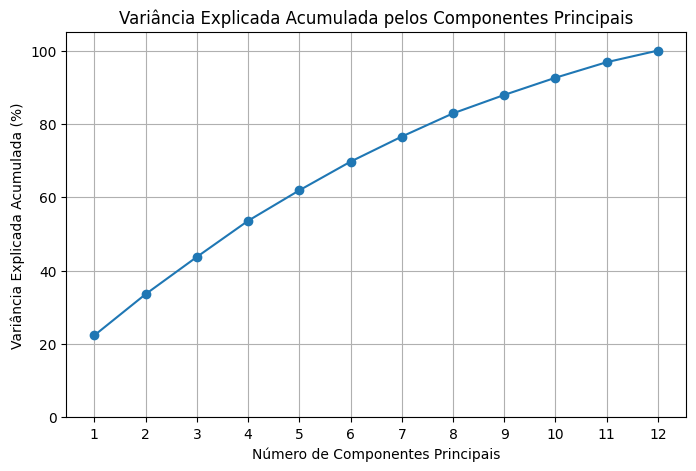

In [13]:
import numpy as np
import pandas as pd

# carregar dados

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
dados = data_train.iloc[:, 1:13].values    # apenas as 12 features

# N = número de amostras
# D = número de dimensões
N, D = dados.shape


# Normalização
mean = np.mean(dados, axis=0)
std  = np.std(dados, axis=0)
std[std == 0] = 1  # evitar divisão por zero

# dados normalizados
X = (dados - mean) / std


# Matriz de Covariância S
S = (1/N) * (X.T @ X)


# Calculo de autovetores e autovalores
# Su = λu
autovalores, autovetores = np.linalg.eig(S)

# autovalores → variâncias explicadas por cada componente
# autovetores → vetores principais (u_k)


# ordenar autovetores e autovalores

idx = np.argsort(autovalores)[::-1]

autovalores = autovalores[idx]
autovetores = autovetores[:, idx]

# Mtriz U
U = autovetores


# Dados projetados

P = U.T @ X.T
P = P.T


# Variância Explicada

variancia_total = np.sum(autovalores)
variancia_explicada = autovalores / variancia_total

variancia_acumulada = np.cumsum(variancia_explicada)



print("\nAutovetores (variância de cada componente):\n", autovalores)
print("\nProporção da variância explicada:\n", variancia_explicada)
print("\nVariância acumulada:\n", variancia_acumulada)



import matplotlib.pyplot as plt
import numpy as np

# Número de componentes (1 até 12)
num_componentes = np.arange(1, len(variancia_acumulada) + 1)

plt.figure(figsize=(8, 5))
plt.plot(num_componentes, variancia_acumulada * 100, marker='o')
plt.title("Variância Explicada Acumulada pelos Componentes Principais")
plt.xlabel("Número de Componentes Principais")
plt.ylabel("Variância Explicada Acumulada (%)")
plt.grid(True)
plt.xticks(num_componentes)
plt.ylim(0, 105)

plt.show()

# Exercício 3

Implemente uma segunda rede neural para fazer a classificação usando o número de componentes principais necessário para incluir 90% da variância explicada. Calcule a acurácia obtida nos dados de teste.

## Resolução

In [17]:
"""
k = np.argmax(variancia_acumulada >= 0.90) + 1
print("Número de componentes necessários para 90% de variância =", k)


# Transformar treino e teste para PCA
X_train_pca = ((dados_treino_np[:, 1:13] - mean) / std) @ U[:, :k]
X_test_pca  = ((dados_teste_np[:, 1:13]  - mean) / std) @ U[:, :k]

# Labels
y_train = dados_treino_np[:, 13].astype(int)
y_test  = dados_teste_np[:, 13].astype(int)
"""

class PCA_Model(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(k, 16),
            nn.ReLU(),
            nn.Linear(16, 12),
            nn.ReLU(),
            nn.Linear(12, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.model(x)


def criar_dataloader_pca(X, y, batch=32):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    dataset = data.TensorDataset(X_tensor, y_tensor)
    loader = data.DataLoader(dataset, batch_size=batch, shuffle=True)
    return loader

# número de componentes para 90%
k = np.argmax(variancia_acumulada >= 0.90) + 1
print("Número de componentes necessários para 90% da variância =", k)

# preparar dataloaders
train_loader_pca = criar_dataloader_pca(X_train_pca, y_train)
test_X_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
test_y_tensor = torch.tensor(y_test, dtype=torch.long)

# modelo
pca_model = PCA_Model(k).to(device)

# treino
optimizer = torch.optim.Adam(pca_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(800):
    for Xb, yb in train_loader_pca:
        Xb, yb = Xb.to(device), yb.to(device)

        pca_model.train()
        optimizer.zero_grad()
        out = pca_model(Xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()

    if epoch % 40 == 0:
        print(f"Época {epoch} - Loss = {loss.item():.4f}")

# teste
pca_model.eval()
with torch.no_grad():
    logits = pca_model(test_X_tensor.to(device))
    preds = torch.argmax(logits, dim=1)
    acc_pca = (preds == test_y_tensor.to(device)).float().mean().item()

print(f"\nAcurácia no teste usando PCA com {k} componentes: {acc_pca*100:.2f}%")




Número de componentes necessários para 90% de variância = 10
Número de componentes necessários para 90% da variância = 10
Época 0 - Loss = 0.6911
Época 40 - Loss = 0.2427
Época 80 - Loss = 0.0547
Época 120 - Loss = 0.0230
Época 160 - Loss = 0.0031
Época 200 - Loss = 0.0013
Época 240 - Loss = 0.0007
Época 280 - Loss = 0.0001
Época 320 - Loss = 0.0002
Época 360 - Loss = 0.0000
Época 400 - Loss = 0.0000
Época 440 - Loss = 0.0000
Época 480 - Loss = 0.0000
Época 520 - Loss = 0.0000
Época 560 - Loss = 0.0000
Época 600 - Loss = 0.0000
Época 640 - Loss = 0.0000
Época 680 - Loss = 0.0000
Época 720 - Loss = 0.0000
Época 760 - Loss = 0.0000

Acurácia no teste usando PCA com 10 componentes: 98.67%


# Exercício 4

Repita os exercícios 1, 2 e 3, considerando a transformação dos dados usando o LDA no lugar do PCA. Use como referência o exemplo mostrado [neste Jupyter Notebook](./LDA_IRIS.ipynb)

## Resolução

In [18]:
#1

# Mesmo modelo do item 1

import torch
import torch.nn as nn
import torch.utils.data as data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar dados
data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test  = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

dados_treino_np = data_train.values
dados_teste_np  = data_test.values


# Normalização dos dados de treino
X_train = dados_treino_np[:, 1:13]
X_test  = dados_teste_np[:, 1:13]

# Média e desvio do treino
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)

# Evita divisão por zero
std[std == 0] = 1.0

# Normaliza
X_train_norm = (X_train - mean) / std
X_test_norm  = (X_test  - mean) / std

# Recria os arrays completos normalizados (saída permanece a mesma)
dados_treino_norm = dados_treino_np.copy()
dados_treino_norm[:, 1:13] = X_train_norm

dados_teste_norm = dados_teste_np.copy()
dados_teste_norm[:, 1:13] = X_test_norm


# Modelo com ReLU
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(12, 16),
            nn.ReLU(),

            nn.Linear(16, 12),
            nn.ReLU(),

            nn.Linear(12, 8),
            nn.ReLU(),

            nn.Linear(8, 2)  # saída binária
        )

    def forward(self, x):
        return self.model(x)


# Dataloader
def criar_dataloader(dados_np, Nb):
    dados = torch.tensor(dados_np, dtype=torch.float32)

    dataset = [
        (dados[i, 1:13], dados[i, 13].long())
        for i in range(dados.shape[0])
    ]

    loader = data.DataLoader(dataset, batch_size=Nb, shuffle=True)
    return loader


# Treinamento
def treino(model, train_loader, Ne, device):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()

    losses = []
    model.to(device)

    for epoch in range(Ne):
        for n, (X, d) in enumerate(train_loader):

            X, d = X.to(device), d.to(device)

            model.train()
            model.zero_grad()

            y = model(X)
            loss = loss_function(y, d)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        if epoch % 40 == 0:
            print(f"Época {epoch} - Loss {loss.item():.4f}")

    plt.figure()
    plt.plot(losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Curva de treinamento")
    plt.show()

    return losses


# Teste
def testar(model, dados_np, device):
    dados = torch.tensor(dados_np, dtype=torch.float32)

    X = dados[:, 1:13].to(device)
    y_true = dados[:, 13].long().to(device)

    model.eval()
    with torch.no_grad():
        logits = model(X)
        pred = torch.argmax(logits, dim=1)

    acc = (pred == y_true).float().mean().item()
    print(f"Acurácia no teste = {acc*100:.2f}%")

    return acc


# Execução
device = "cuda" if torch.cuda.is_available() else "cpu"

Nb = 32
Ne = 520

train_loader = criar_dataloader(dados_treino_norm, Nb)
model = Model()

losses = treino(model, train_loader, Ne, device)

testar(model, dados_teste_norm, device)




In [19]:
# 2

#